<a href="https://colab.research.google.com/github/jeonghyunwoo/ML/blob/master/smp_crawling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import requests
import pandas as pd

def smp(yyyymmdd = pd.datetime.today().strftime('%Y%m%d')):
  url = f"https://www.kpx.or.kr/www/contents.do?key=225&status=land&issueDate={yyyymmdd}&__encrypted=bWMSYnoNUQZWNlsXn4c3D93ovZYSTGXWpNeR1G3EL4XFmBSGdP6jxjQxV0fCOiclQIn%2Byg9Ic9UOnemx54yY3Z0Cjbp89g%2Bmmdfs37WPlls%3D"
  html = requests.get(url).content
  df_list = pd.read_html(html)
  df = df_list[-1]
  dt0 = pd.to_datetime(yyyymmdd,format='%Y%m%d')
  cols = ['구분'] + pd.date_range(end=dt0, periods=7).strftime('%y.%m.%d %a').tolist()
  
  df.columns = cols
  return df

In [0]:
def smp_ts(days=90):
    dts = []
    today = pd.datetime.today().strftime('%Y-%m-%d')
    dat_lst = pd.date_range(end = today, periods=days)[::-7].strftime('%Y%m%d').values.tolist()
    for d in dat_lst:
        dt = smp(d)
        dt = dt.melt(id_vars='구분',var_name='date',value_name='smp_price')
        dts.append(dt)
    res = pd.concat(dts, axis=0)
    res.date = pd.to_datetime(res.date, format='%y.%m.%d %a')
    res['gb'] = np.where(res.구분.str.endswith('h'),'시간별','일별')
    return res        

In [0]:
def smp_hd(df_ts,gb='시간별'):
    '''
    df_hour = smp_hd(df_ts, gb='시간별')
    df_day = smp_hd(df_ts, gb='일별')
    '''
    if gb=='시간별':
        res = df_ts.loc[df_ts.gb=='시간별'].drop('gb',axis=1).rename(columns={'구분':'시간대'})
        res.시간대 = res.시간대.str.replace('h','').astype(int)
    elif gb=='일별':
        res = df_ts.loc[df_ts.gb=='일별'].drop('gb',axis=1).pivot(index='date',columns='구분',values='smp_price')
    return res

In [0]:
%%time
df_ts = smp_ts(1825)

Wall time: 8min 58s


In [0]:
# 시간별 데이터와 일별 가중평균/최대/최소 데이터로 나눔
df_h, df_d  = smp_hd(df_ts,'시간별'), smp_hd(df_ts,'일별')

In [0]:
ma30 = df_d.가중평균.rolling(30).mean()
ma90 = df_d.가중평균.rolling(90).mean()
ma180 = df_d.가중평균.rolling(180).mean()

In [0]:
mas = pd.concat([df_d.가중평균,ma30,ma90,ma180],axis=1)
mas.columns = ['daily','ma30','ma90','ma180']

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
sns.set(style='whitegrid')

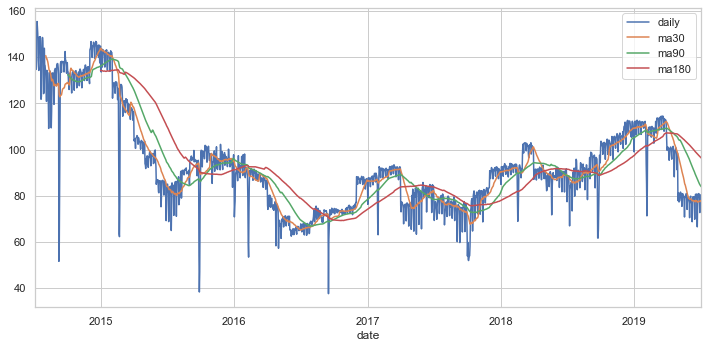

In [0]:
fig, ax = plt.subplots(figsize=(10,5))
mas.plot(ax = ax)
plt.tight_layout()